## Load

In [174]:
import pandas as pd
import numpy as np
from os import path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [175]:
data = pd.read_csv(path.join('Data', 'mushrooms.csv'))

In [176]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [177]:
y = data['class']
X = data.drop(columns='class')

## Clean

In [178]:
data.count()

class                       8124
cap-shape                   8124
cap-surface                 8124
cap-color                   8124
bruises                     8124
odor                        8124
gill-attachment             8124
gill-spacing                8124
gill-size                   8124
gill-color                  8124
stalk-shape                 8124
stalk-root                  8124
stalk-surface-above-ring    8124
stalk-surface-below-ring    8124
stalk-color-above-ring      8124
stalk-color-below-ring      8124
veil-type                   8124
veil-color                  8124
ring-number                 8124
ring-type                   8124
spore-print-color           8124
population                  8124
habitat                     8124
dtype: int64

In [179]:
data.isnull().any()

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

## preprocess

In [180]:
y.unique()

array(['p', 'e'], dtype=object)

In [181]:
y = y.map({'p':1, 'e':0})

In [182]:
X = pd.get_dummies(X, drop_first=True)

In [183]:
(X.count() == 8124).all()

np.True_

## 

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Classification

In [185]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Test

In [186]:
y_pred = lr.predict(X_test)

## Accuracy

In [187]:
accuracy_score(y_test, y_pred)

1.0

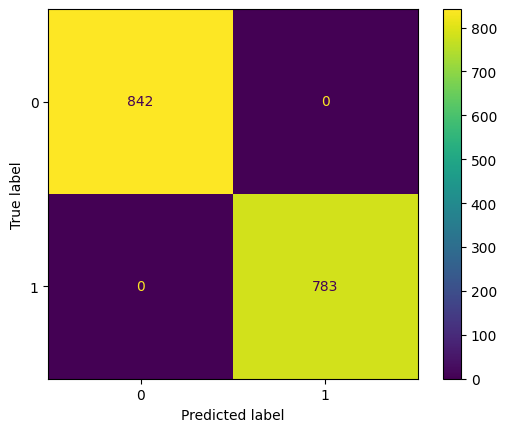

In [188]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [189]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision:',precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Adjust the model to reduce the false negative

In [190]:
lr_adj = LogisticRegression(class_weight={0:1, 1:50})
lr_adj.fit(X_train, y_train)
y_pred_adj = lr_adj.predict(X_test)
print('Recall:', recall_score(y_test, y_pred_adj))

Recall: 1.0


## result

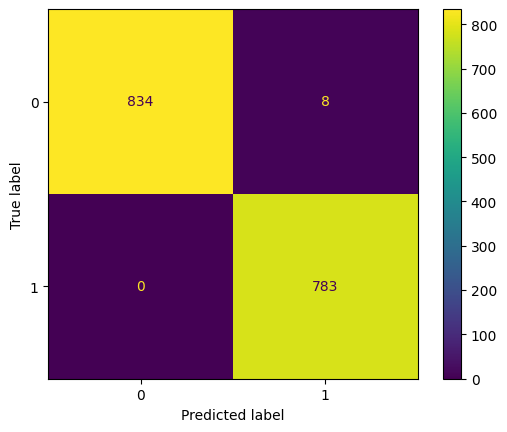

In [191]:
cm = confusion_matrix(y_test, y_pred_adj)
ConfusionMatrixDisplay(cm).plot()

## interpretation

In [192]:
coefs = pd.DataFrame({
    "feature": X.columns,
    "coef": lr_adj.coef_[0],
    "odds_ratio": np.exp(lr_adj.coef_[0])
}).sort_values(by="odds_ratio", ascending=False)

print(coefs.head(10))


                       feature      coef  odds_ratio
28                 gill-size_n  6.272525  529.813715
80         spore-print-color_r  5.785336  325.491272
19                      odor_f  5.010106  149.920649
41                stalk-root_b  4.429653   83.902264
23                      odor_p  4.238304   69.290240
18                      odor_c  3.673550   39.391492
45  stalk-surface-above-ring_k  3.107614   22.367602
84                population_c  2.690775   14.743096
73                 ring-type_l  2.229166    9.292117
76         spore-print-color_h  2.168989    8.749432


<BarContainer object of 10 artists>

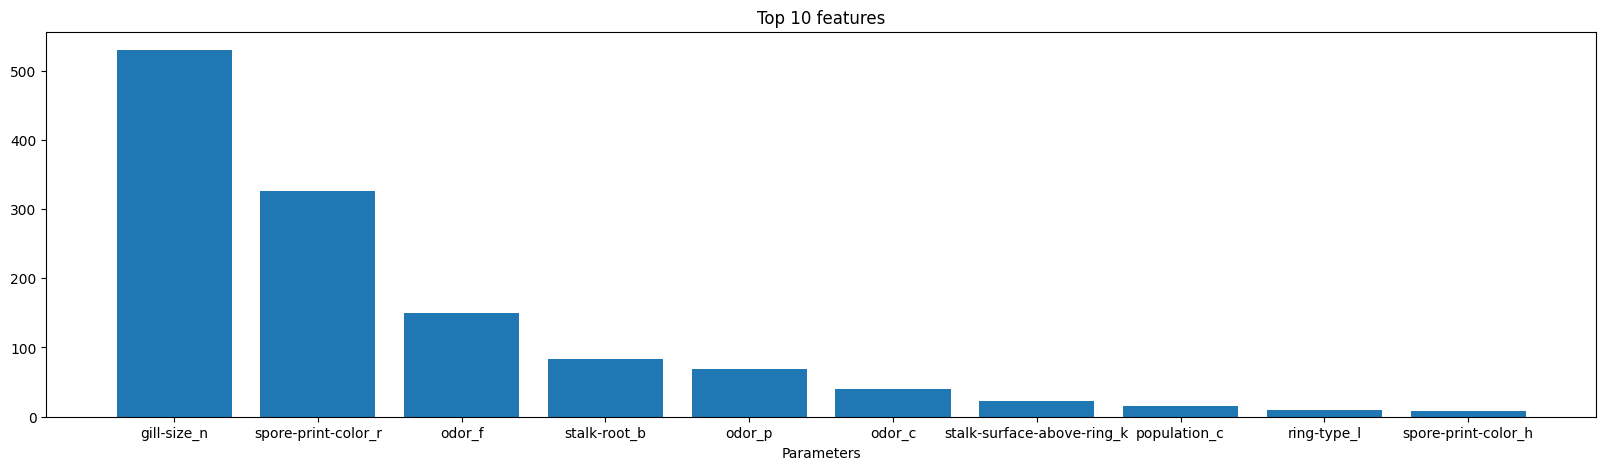

In [193]:
plt.figure(figsize=(20,5))
plt.xlabel("Parameters")
plt.title("Top 10 features")
plt.bar(coefs.head(10).feature, coefs.head(10).odds_ratio)

In [194]:
r = permutation_importance(lr_adj, X, y, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": r.importances_mean,
    "std": r.importances_std
}).sort_values(by="importance", ascending=False)

print(imp_df.head(10))

                       feature  importance       std
22                      odor_n    0.056044  0.001750
28                 gill-size_n    0.030908  0.000817
19                      odor_f    0.018796  0.001557
41                stalk-root_b    0.017688  0.001178
27              gill-spacing_w    0.013922  0.000442
45  stalk-surface-above-ring_k    0.007669  0.000718
48  stalk-surface-below-ring_k    0.003299  0.000590
78         spore-print-color_n    0.003127  0.000496
80         spore-print-color_r    0.002942  0.000194
72                 ring-type_f    0.002560  0.000049


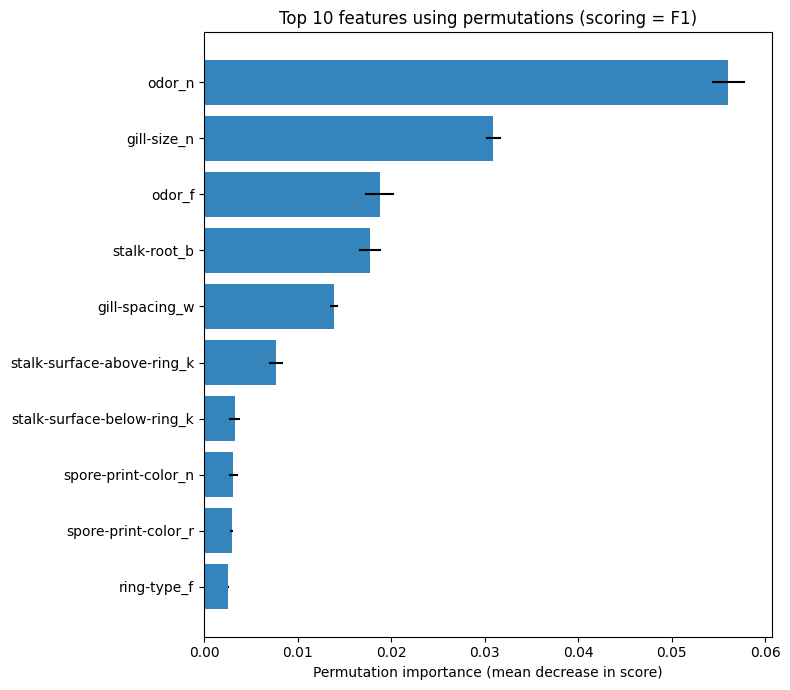

In [195]:
top = imp_df.head(10).iloc[::-1]
plt.figure(figsize=(8, 7))
plt.barh(top["feature"], top["importance"], xerr=top["std"], alpha=0.9)
plt.xlabel("Permutation importance (mean decrease in score)")
plt.title("Top 10 features using permutations (scoring = F1)")
plt.tight_layout()
plt.show()